In [1]:
import json
import jax
import numpy as np
from functools import partial
import torch
from sklearn.neighbors import KernelDensity
from sklearn.impute import KNNImputer
from scipy import stats

# SBI
from sbi.inference import SNPE
from sbi.utils import BoxUniform

# Some small helper functions
from probjax.distributions.discrete import Empirical
from probjax.distributions.independent import Independent
from probjax.distributions.sde import VESDE
from train_interface.data_handling import *
from train_interface.Visualize import *

from train_interface.build_transfomer_model import BuildTransformerModel
from train_interface.wrapper import SimFormer
from train_interface.config_class import TrainingConfig, SDEConfig, SimformerConfig, TransformerConfig, DiffusionConfig, set_config_values

# Check CUDA support
jax.devices()  # Should be cuda

[CpuDevice(id=0)]

In [2]:
# Set random key
key = jax.random.PRNGKey(5)

### 1) Data Generation


## Data Generation Functions

### **Theta Generation**
- $\theta_1 \sim \text{Normal distribution scaled by 3}$
- $\theta_2 \sim \text{Normal distribution scaled by 2}$

---

### **Data Features Calculation**
- **$x_1$** = $2 \cdot \sin(\theta_1) + 3 \cdot \cos(\theta_2) + \text{Normal noise scaled by 0.5}$
- **$x_2$** = $0.1 \cdot \theta_1^2 + 0.5 \cdot |x_1| \cdot \text{Normal noise}$
- **$x_3$** = $0.5 \cdot \theta_2 + 0.2 \cdot |x_2| \cdot \text{Normal noise}$


In [3]:
# this switch is to indicate if you want to work with the csv file or just simulated example data
error = 0.5
def generate_data_combined_normal(key: jrandom.PRNGKey, n: int):
    key1, key2, key3, key4, key5 = jrandom.split(key, 5)
    theta1 = jrandom.normal(key1, (n, 1)) * 3
    theta2 = jrandom.normal(key4, (n, 1)) * 2

    x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(key2, (n, 1)) * 0.5
    x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
    x3 = 0.5 * theta2 + 0.2 * jnp.abs(x2) * jrandom.normal(key5, (n, 1))

    data = jnp.concatenate([theta1, theta2, x1, x2, x3], axis=1).reshape(n, -1, 1)
    data_with_nans = random_nan(data, key, error)

    # Normalize data
    normalized_data, means, stds = normalize_data(data_with_nans)
    data_norm = normalize_with_params(data, means, stds)

    return normalized_data, data_norm, data_with_nans, data, means, stds

def generate_data_combined_normal_par(key: jrandom.PRNGKey, n: int, means, stds):
    key1, key2, key3, key4, key5 = jrandom.split(key, 5)
    theta1 = jrandom.normal(key1, (n, 1)) * 3
    theta2 = jrandom.normal(key4, (n, 1)) * 2

    x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(key2, (n, 1)) * 0.5
    x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
    x3 = 0.5 * theta2 + 0.2 * jnp.abs(x2) * jrandom.normal(key5, (n, 1))

    data = jnp.concatenate([theta1, theta2, x1, x2, x3], axis=1).reshape(n, -1, 1)
    data_with_nans = random_nan(data, key, error)

    # Normalize data
    normalized_data= normalize_with_params(data_with_nans, means, stds)
    data = normalize_with_params(data, means, stds)
        
    return normalized_data, data

# 2 Create Data for all tries

This just creates the data using the functions above

In [9]:
# important here amount of data does it change something ?
data, data_clean, data_no_norm, data_clean_no_norm, means, stds = generate_data_combined_normal(
    jrandom.PRNGKey(1), 2**13
)  # Shape: (n, nodes, dim) here dim = 1
# nodes max = how many data points
nodes_max = data_clean.shape[1]
# creates id for notes ?
node_ids = jnp.arange(nodes_max)
print(data.shape)
# check if nan values are present
print(jnp.isnan(data).sum())
n_features = data.shape[1]
labels = [f"x{i+1}" for i in range(n_features)]  # Automatically generate labels

(8192, 5, 1)
20480


# 3) Config part

In [11]:
# Initialize the dataclasses with zero or default values
sde_config = SDEConfig()
simformer_config = SimformerConfig()
transformer_config = TransformerConfig()
training_config = TrainingConfig()
diffusion_config = DiffusionConfig()

# Define values to set for each config parameter for multiple configurations
with open('simformer_config.json', 'r') as f:
    config_set = json.load(f)

set_config_values(sde_config, config_set["SDEConfig"])
set_config_values(simformer_config, config_set["SimformerConfig"])
set_config_values(transformer_config, config_set["TransformerConfig"])
set_config_values(training_config, config_set["TrainingConfig"])
set_config_values(diffusion_config, config_set["DiffusionConfig"])

T = sde_config.T
T_min = sde_config.T_min
sigma_min = sde_config.sigma_min
sigma_max = sde_config.sigma_max

dim_value = simformer_config.dim_value
dim_id = simformer_config.dim_id
dim_condition = simformer_config.dim_condition

num_heads = transformer_config.num_heads
num_layers = transformer_config.num_layers
attn_size = transformer_config.attn_size
widening_factor = transformer_config.widening_factor

epochs = training_config.epochs
time_steps = diffusion_config.time_steps

# Print or run the experiment for the current configuration
print(f"SDEConfig: {sde_config}")
print(f"SimformerConfig: {simformer_config}")
print(f"TransformerConfig: {transformer_config}")
print(f"TrainingConfig: {training_config}")
print(f"DiffusionConfig: {diffusion_config}")
print("---" * 20)

SDEConfig: SDEConfig(T=1.0, T_min=0.01, sigma_min=0.001, sigma_max=15.0)
SimformerConfig: SimformerConfig(dim_value=20, dim_id=20, dim_condition=10)
TransformerConfig: TransformerConfig(num_heads=2, num_layers=3, attn_size=30, widening_factor=3)
TrainingConfig: TrainingConfig(epochs=1000)
DiffusionConfig: DiffusionConfig(time_steps=500)
------------------------------------------------------------


# 4) Main Part of the Simformer

In [12]:
# This creates the SDE for noise in diffusion model
data_clean = data.copy()
# impute NaNs with 0
data_clean = jnp.nan_to_num(data_clean, 0.0)
# fill nans with 0
batch_xs_clean = jnp.nan_to_num(data_clean, 0.0)

p0 = Independent(Empirical(data_clean), 1)
sde = VESDE(p0, sigma_min=sigma_min, sigma_max=sigma_max)
tm = BuildTransformerModel(sde, nodes_max, dim_value, dim_id, dim_condition, num_heads, num_layers, attn_size, widening_factor)
init, model_fn = tm()

In [25]:
# put data into the model i guess
params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))
# Here we can see the total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

# model training class
tsm = SimFormer(
    time_steps=time_steps,
    key=key, data=data, sde=sde, model_fn=model_fn, params=params, T_min=T_min,
    nodes_max=nodes_max, batch_size=512,
    lr=1e-3, inner_train_loop_size=100, model_check_point_dir='model_checkpoint'
)

Total number of parameters:  102566


In [30]:
model_path_name = None #'model_checkpoint/toy5D.pkl'

if model_path_name is not None:
    tsm.load_best_model(model_path_name)
else:
    print("No model saved, fitting anew")
    tsm.fit(epochs=100)

No model saved, fitting anew
Epoch 1 loss: 51.38284683227539
Epoch 2 loss: 45.30101013183594
Epoch 3 loss: 42.2562141418457
Epoch 4 loss: 40.147098541259766
Epoch 5 loss: 38.84232711791992
Epoch 6 loss: 38.408836364746094
Best parameters saved at epoch 6
Epoch 7 loss: 37.91158676147461
Best parameters saved at epoch 7


KeyboardInterrupt: 

In [32]:
tsm.load_best_model('model_checkpoint/model_checkpoint_epoch_6.pkl')

Best parameters loaded from model_checkpoint/model_checkpoint_epoch_6.pkl


In [33]:
ys = tsm.sample_fn(
    jrandom.PRNGKey(0), (1_000,), condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,))
)
samples = (ys[:,-1,:] * stds) + means

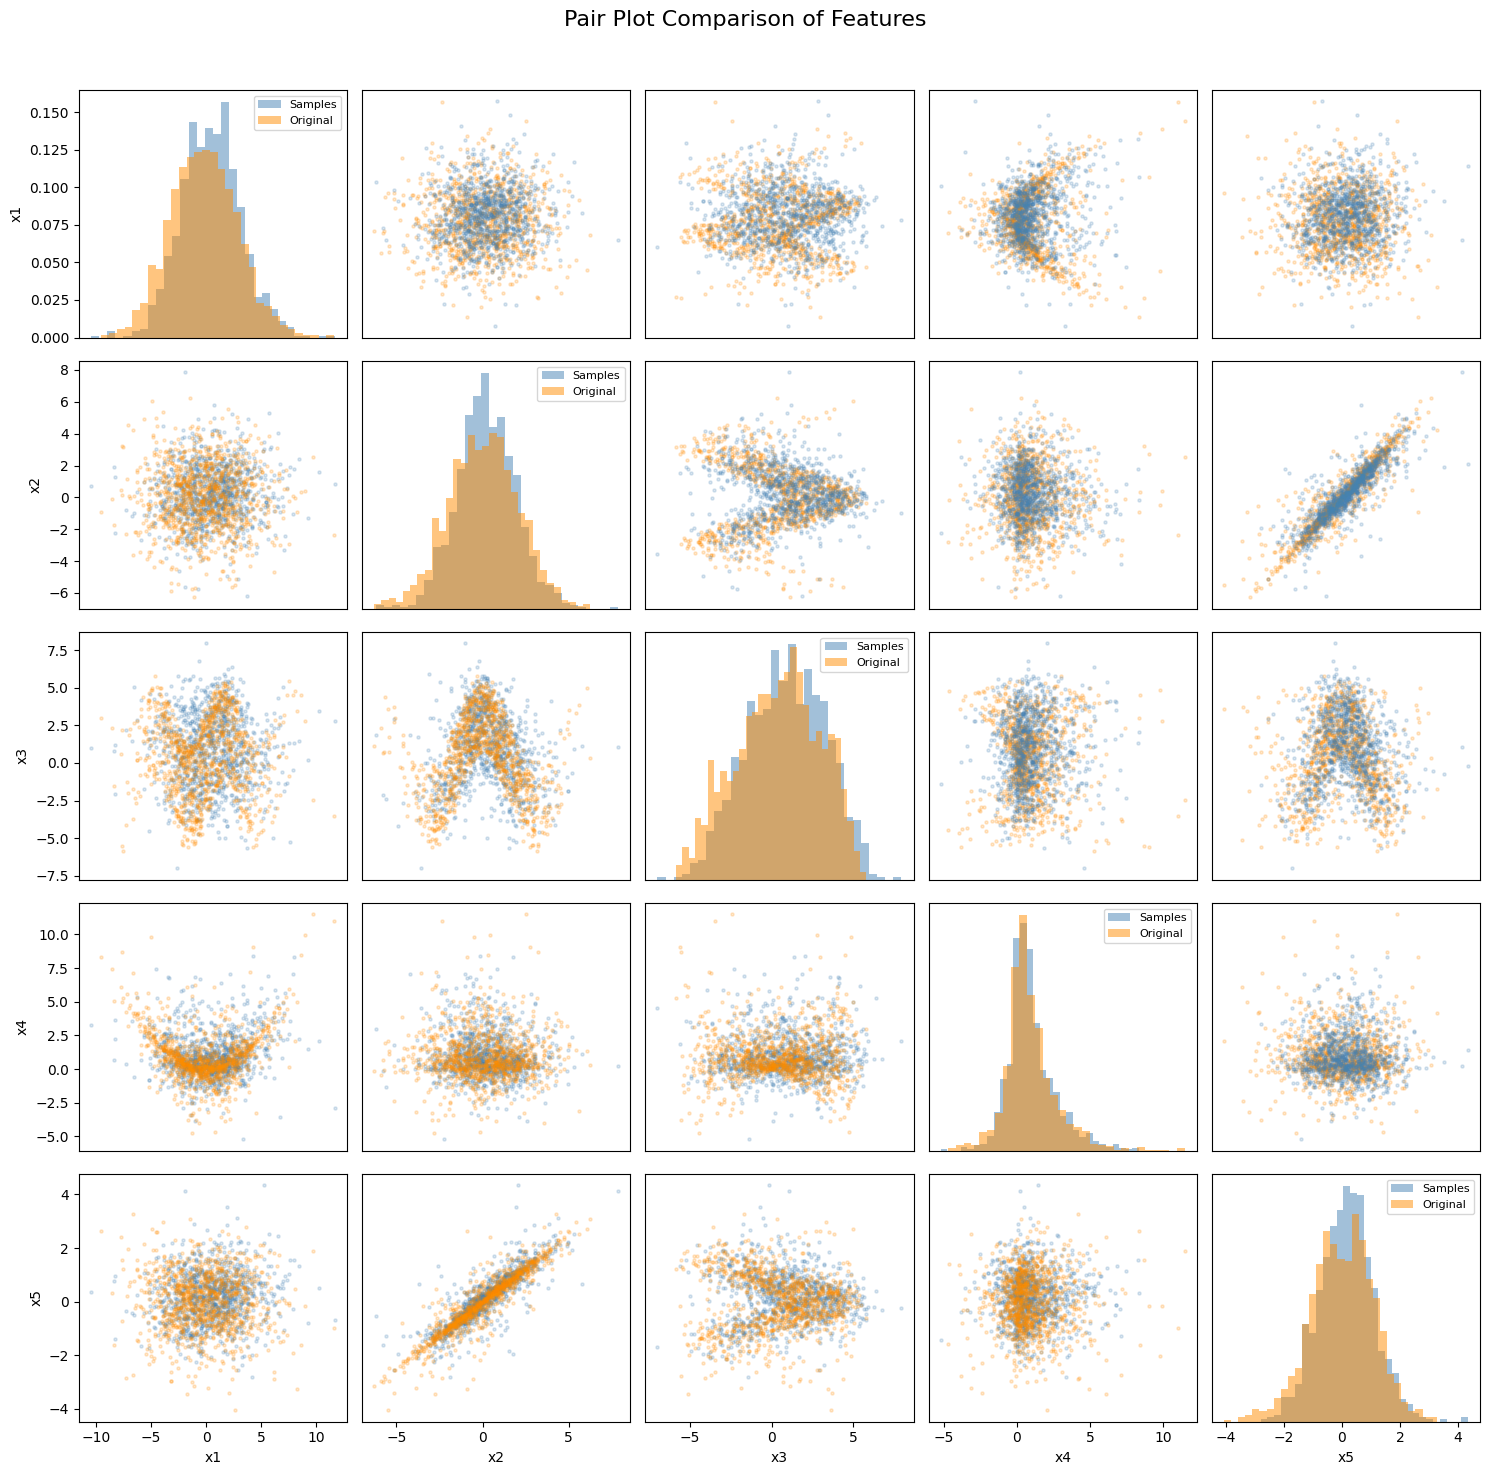

In [34]:
# Full joint estimation
# Taking samples and visualizing them (after some formation)
samples_new = samples
data_new = data_clean_no_norm[:, :, -1][:1_000]
plot_pairplot_comparison_points(samples_new, data_new, labels, dataset_labels=('Samples', 'Original'))
# plot_pairplot_comp_kde2(samples_new, data_new, labels)

# 5) Testing Sampling

Here it is shown how good the simformer works by testing the sampling.

For that a point is generated from the data generation function. 
Then SBI/Simformer perform Sampling and sample 1000 points for theta1 based on all the other parameters (theta2,x1,x2,x3)

## Testing the Simformer

Iteration 1/100 - Metric (Log KDE): -1.895384326291408
Iteration 2/100 - Metric (Log KDE): -2.0177807701934984
Iteration 3/100 - Metric (Log KDE): -1.3347881465503644
Iteration 4/100 - Metric (Log KDE): -1.3000780425550005
Iteration 5/100 - Metric (Log KDE): -1.6189186968526688
Iteration 6/100 - Metric (Log KDE): -2.673566933416855
Iteration 7/100 - Metric (Log KDE): -0.5391720213356628
Iteration 8/100 - Metric (Log KDE): -1.5462057492830859
Iteration 9/100 - Metric (Log KDE): -1.0053160419338916
Iteration 10/100 - Metric (Log KDE): -1.5177063349161894
Iteration 10/100 completed.
Iteration 11/100 - Metric (Log KDE): -2.7318862305859763
Iteration 12/100 - Metric (Log KDE): -1.5617553301976042
Iteration 13/100 - Metric (Log KDE): -1.165639729070346
Iteration 14/100 - Metric (Log KDE): -1.466363044711704
Iteration 15/100 - Metric (Log KDE): -2.2047022399259664
Iteration 16/100 - Metric (Log KDE): -2.1715910121817874
Iteration 17/100 - Metric (Log KDE): -1.5895282573605698
Iteration 18/100

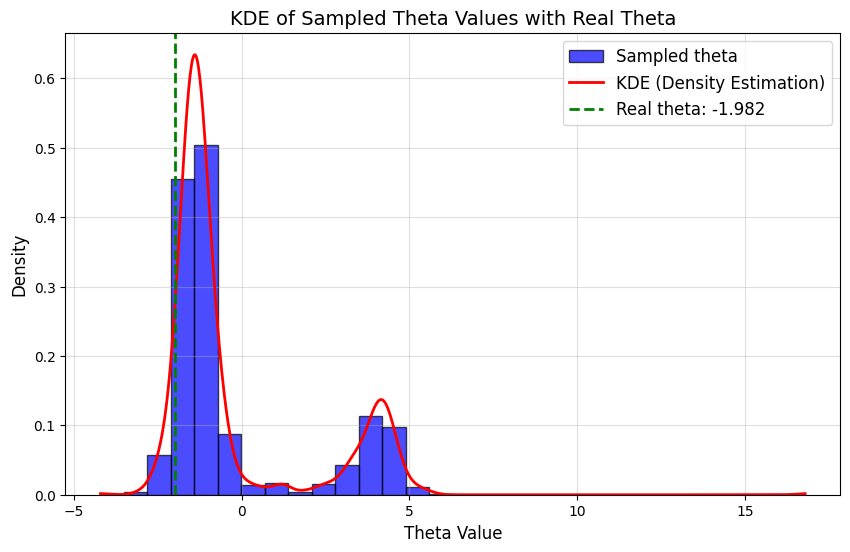

Iteration 100/100 - Metric (Log KDE): -1.2658219308111764
Iteration 100/100 completed.


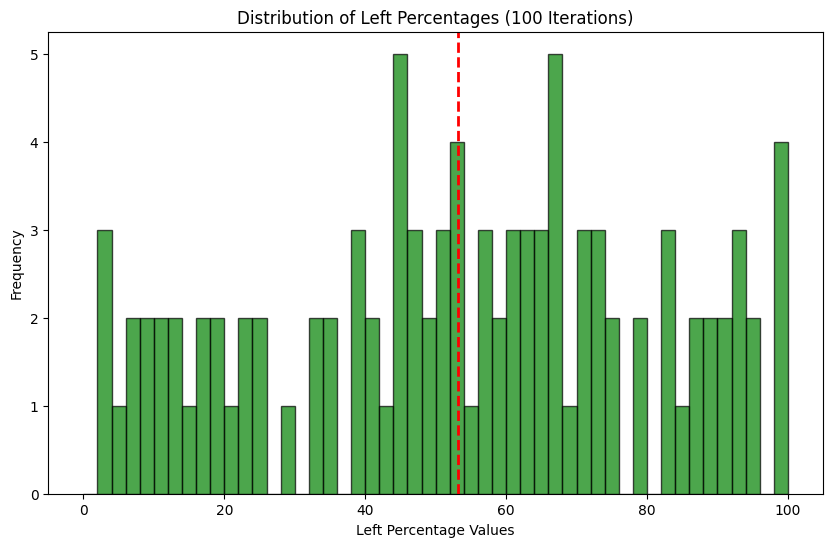

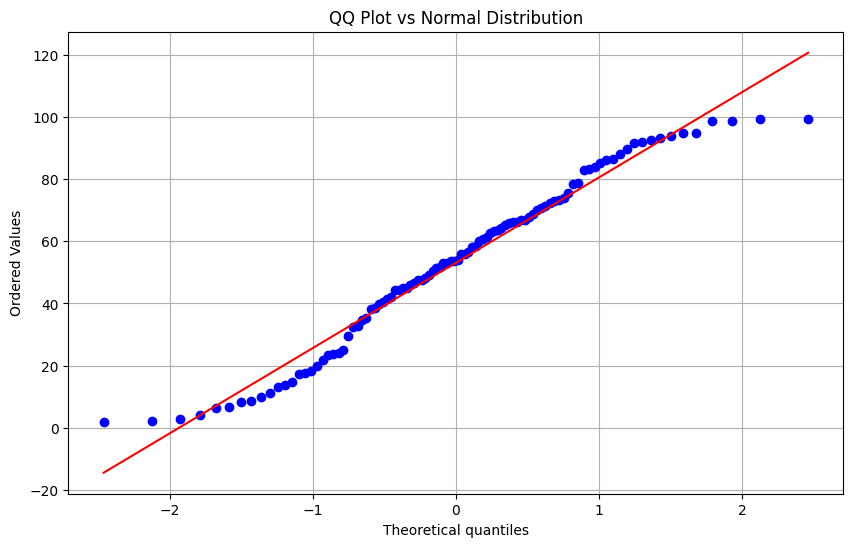

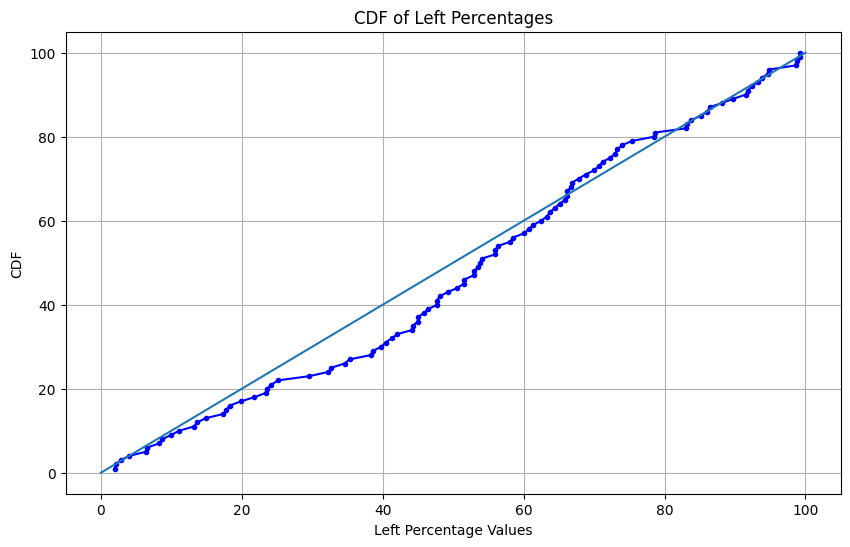

Average Absolute Difference CDF: 3.40
Average Left Percentage: 53.04%
95% Confidence Interval: [47.65%, 58.30%]
Average left percentage: 53.04%
Metric Name                   Value
mean_left_percentage          53.102996826171875
std_left_percentage           27.23745346069336
median_left_percentage        53.95000076293945
ks_statistic                  0.97744
ks_pvalue                     0.00000
mean_kde                      -1.59766
total kde                     -159.76552


In [12]:
# Assuming necessary imports and setup
avg_left, left_percentages, metrics = evaluate_conditional_sampling(
    generate_data_fn=generate_data_combined_normal_par,
    sample_fn=sample_fn,
    denormalize_data=denormalize_data,
    means=means,
    stds=stds,
    node_ids=node_ids,
    iterations=100,
    plot_results=True,
    extended_plot=True,
    samples_new=samples_new,
    data_new=data_new
)

## Testing SBI

Hint: Yout mabeye need to scroll down in the code field to see the final results as sbi displays every step and I can not turn that off

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Generated samples shape: (10000, 5)
Mean of samples: [-0.009  0.008  0.024  0.026  0.089]
Standard deviation of samples: [0.846 0.8   0.916 0.759 0.801]


/srv/home/localusers/alexanderm20/P2/simformer-main/example/alex/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


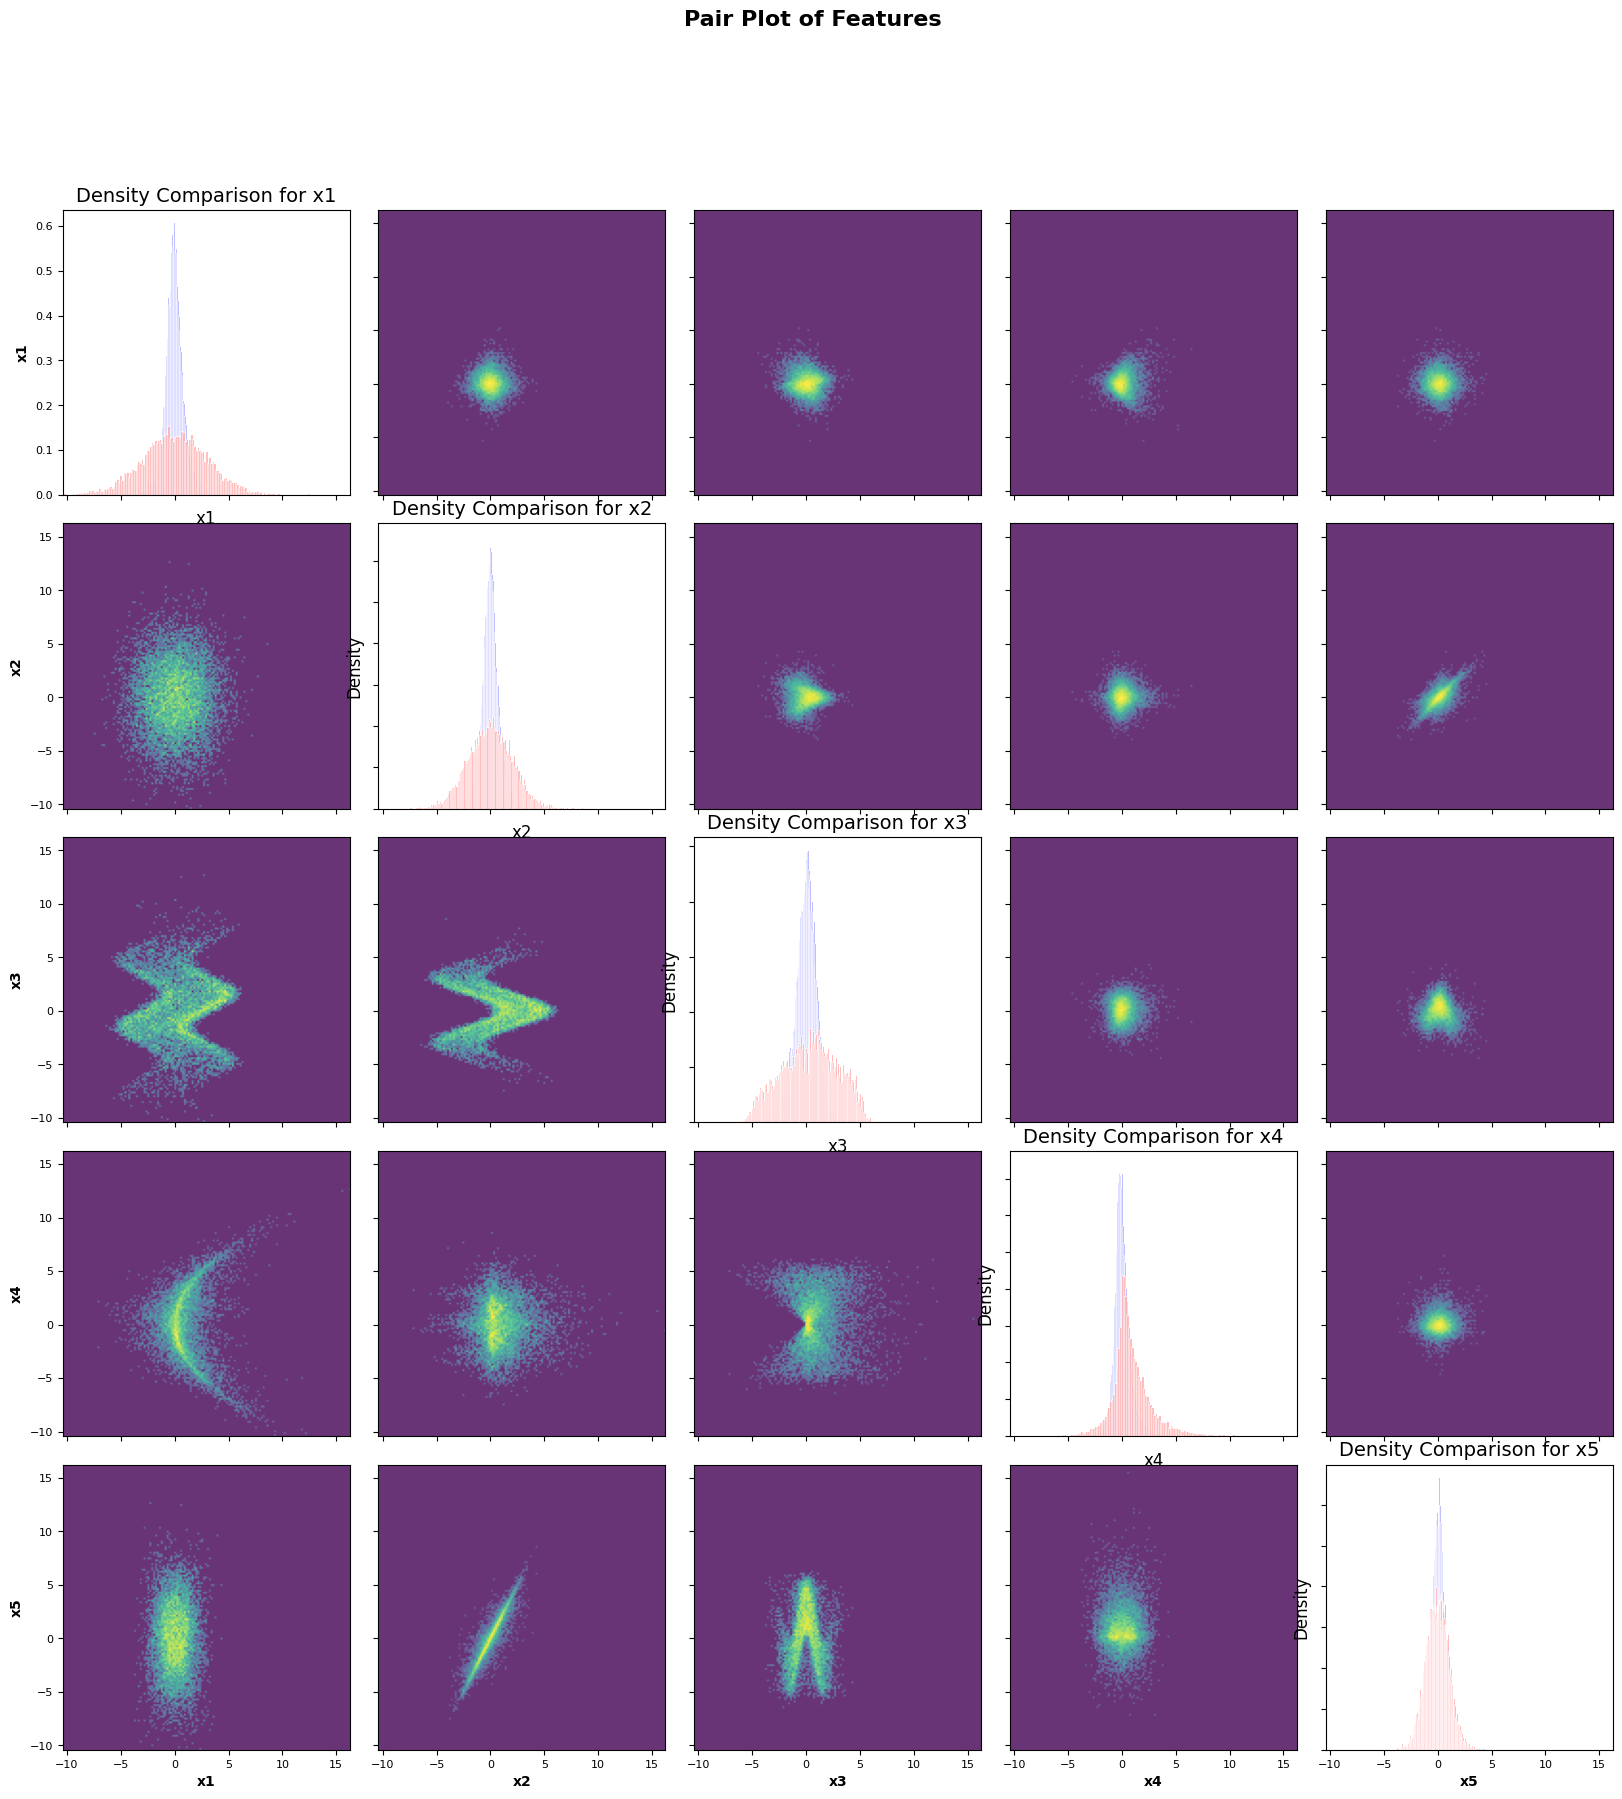

Comparison of Entire Datasets:
KS Statistic (averaged across dimensions) = 0.25224, p-value = 3.831014590402612e-70
Jensen-Shannon Divergence (averaged across dimensions) = 0.26657573019168
Mann-Whitney U Statistic (averaged across dimensions) = 45703996.5, p-value = 0.10885946053501201
High-Dimensional Pearson Correlation (averaged across dimensions) = 0.010467521258490995
High-Dimensional Wasserstein Distance = 3.2002657526454725


/srv/environments/alexanderm20/venvs/job_9503/lib/python3.12/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [10]:
test = torch.zeros(1, 1, dtype=torch.float32)  # Dummy observations
posterior.set_default_x(test)  # Set the default context for unconditioned sampling

# Sample 1000 points without condition from the posterior
num_samples_to_generate = 10000
samples = posterior.sample((num_samples_to_generate,))

# Step 5: Compare sampled points to input data distributions
samples_np = samples.numpy()

print(f"Generated samples shape: {samples_np.shape}")
print(f"Mean of samples: {samples_np.mean(axis=0)}")
print(f"Standard deviation of samples: {samples_np.std(axis=0)}")

plot_pairplot_comp_kde2(samples,data_new,labels)

# 6) Testing Constraints

Here I am testing how adding some constraints (prior knowledge) about functions/variables can improve the result of the results

For the example here, I provide the function for x1 and x2.
This is then added to the loss function of the diffusion model and guides it to respect this constraints. All of the Constraints are normalized and scaling factor can be adjusted (how much loss they generate)



(10000, 5)
[[ 4.995  1.57  -0.745  2.557  0.541]
 [ 1.864  3.278 -1.114 -0.582  1.564]
 [-1.92   0.12   0.715 -0.401 -0.027]
 [-1.69  -0.265  0.983 -0.257 -0.159]
 [-2.161  1.087 -0.115  0.079  0.482]
 [-0.109 -1.729 -2.026  0.756 -0.828]
 [-2.765 -0.933  1.628  1.476 -0.596]
 [ 4.709  0.46   1.51   2.488  0.099]
 [-1.459  1.971 -3.401  0.706  1.007]
 [-2.68  -1.332  1.492  1.823 -0.53 ]]


/Users/ratzenboe/Documents/work/projects/AstroSimformer/new/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


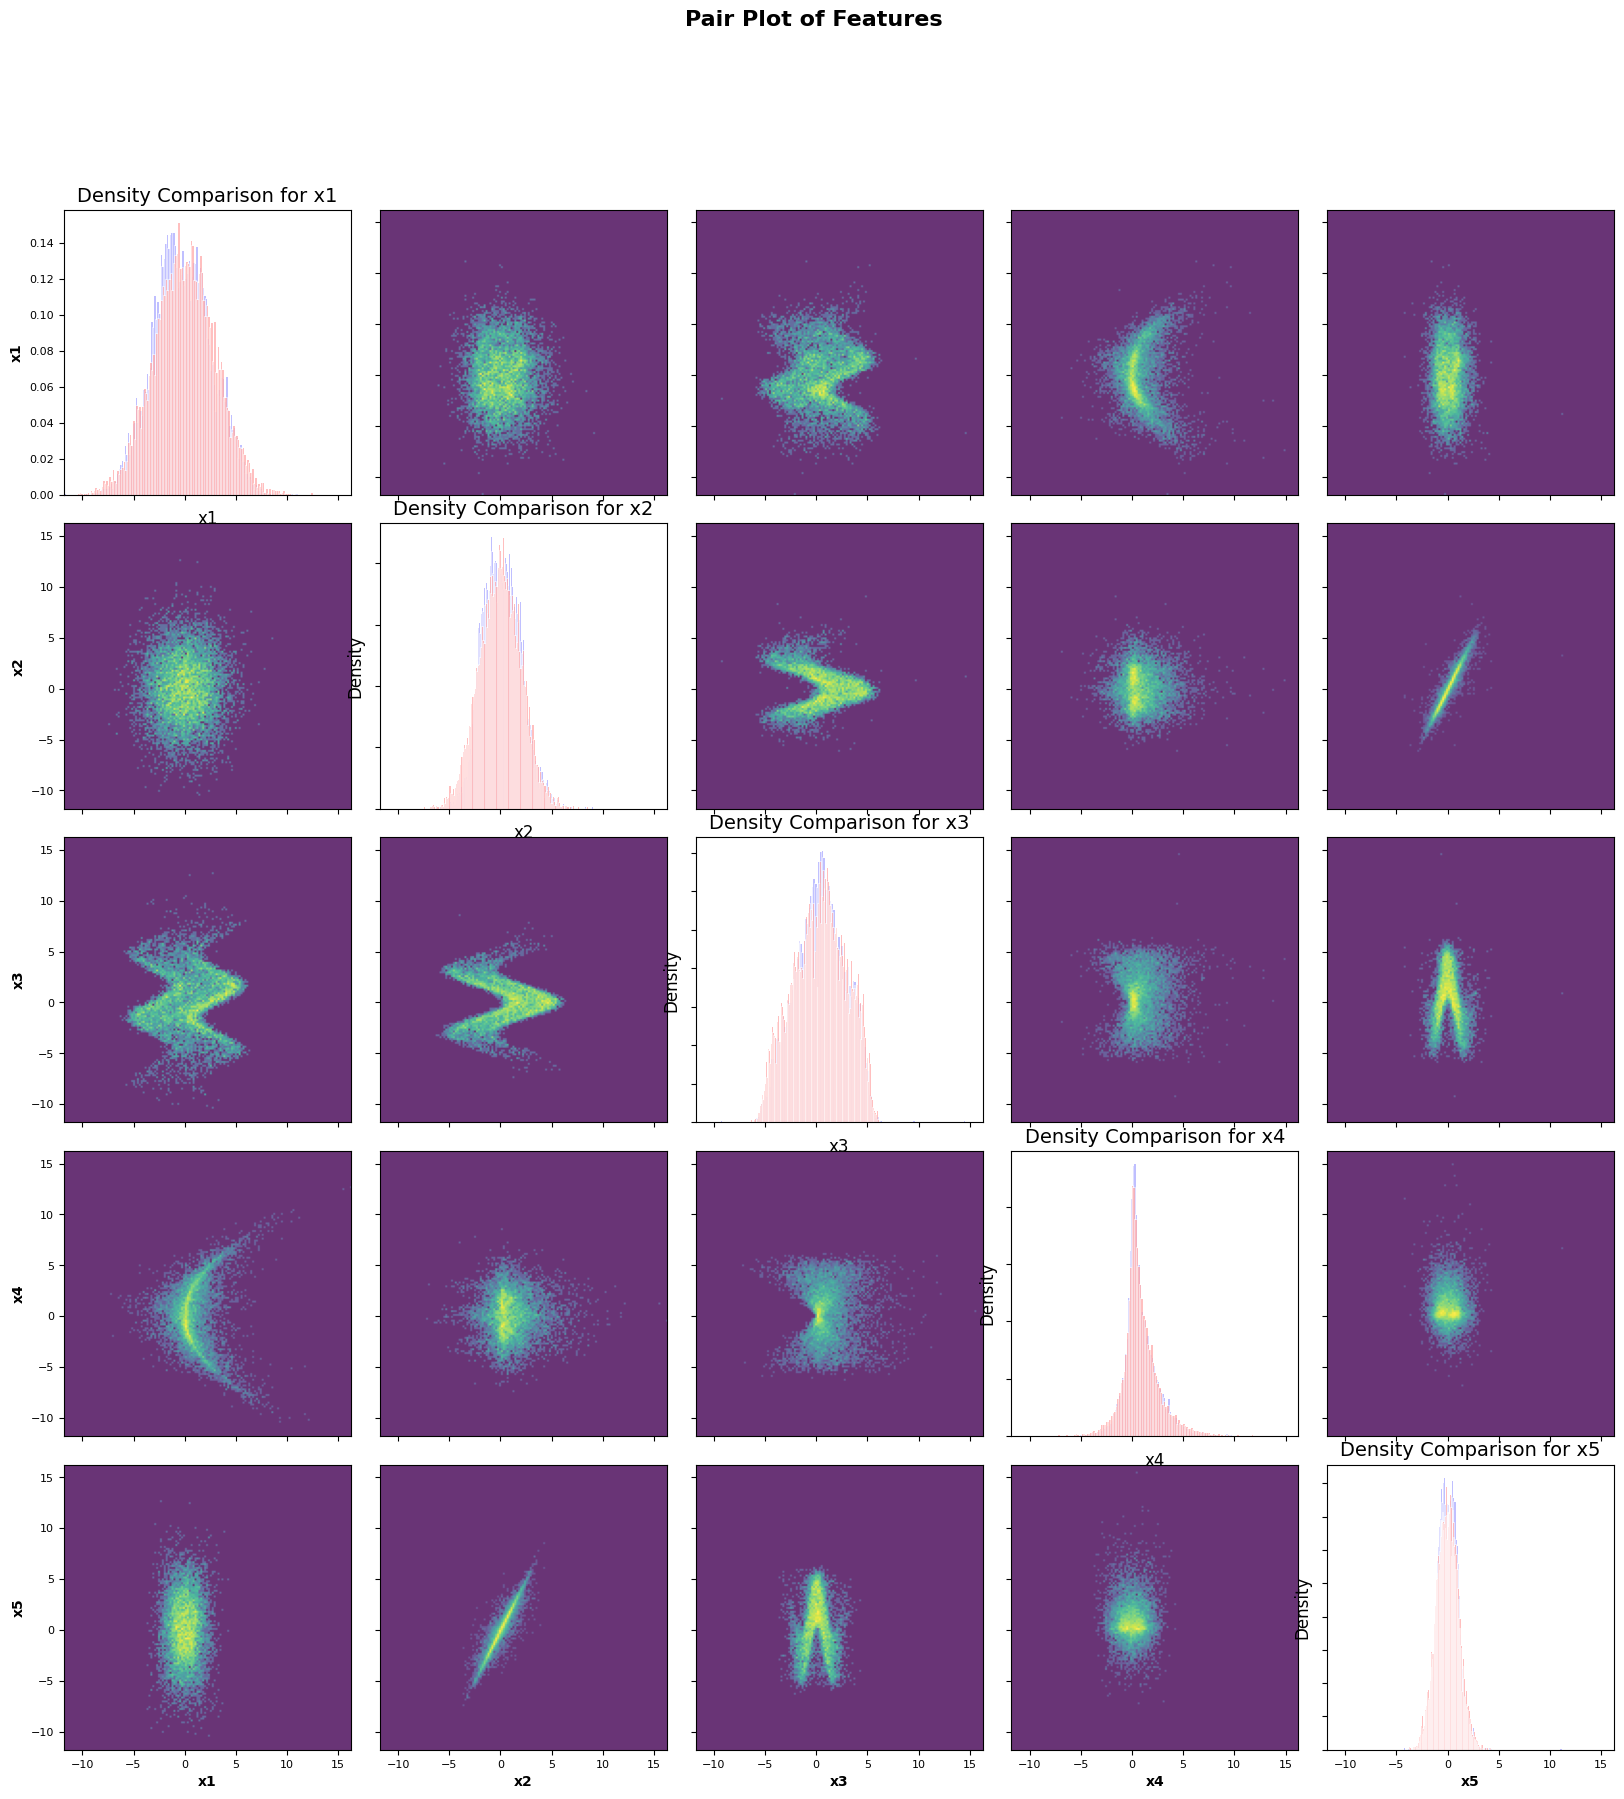

(Array(632162.94, dtype=float32), Array(634370.2, dtype=float32))
Old,New


In [13]:
class Constraint:
    def __init__(self, scale_factor=1000.0):
        self.scale_factor = scale_factor
    
    def evaluate(self, x):
        raise NotImplementedError
        
    def get_penalty(self, t, x):
        violation = self.evaluate(x)
        # Scale penalty based on time and violation magnitude
        scale = jnp.exp(-t**2 * 10) * self.scale_factor
        return scale * violation**2

class NormalizedConstraint(Constraint):
    def __init__(self, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.means = means
        self.stds = stds
    
    def normalize(self, x):
        return (x - self.means) / self.stds
    
    def denormalize(self, x):
        return x * self.stds + self.means

class NormalizedX1Constraint(NormalizedConstraint):
    def __init__(self, key2, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key2 = key2
        self.n = n
    
    def evaluate(self, x):
        x_denorm = self.denormalize(x)
        theta1, theta2, x1 = x_denorm[:, 0], x_denorm[:, 1], x_denorm[:, 2]
        expected_x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(self.key2, (self.n, 1)) * 0.5
        return jnp.abs(x1 - expected_x1)*self.scale_factor

class NormalizedX2Constraint(NormalizedConstraint):
    def __init__(self, key3, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key3 = key3
        self.n = n
    
    def evaluate(self, x):
        x_denorm = self.denormalize(x)
        theta1, x1, x2 = x_denorm[:, 0], x_denorm[:, 2], x_denorm[:, 3]
        expected_x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(self.key3, (self.n, 1))
        return jnp.abs(x2 - expected_x2)*self.scale_factor

class EqualityConstraint(Constraint):
    def __init__(self, indices, coefficients, target_value=0.0, scale_factor=1000.0, penalty_factor=1.0):
        super().__init__(scale_factor)
        self.indices = indices
        self.coefficients = coefficients
        self.target_value = target_value
        self.penalty_factor = penalty_factor  # Add a custom factor to increase penalty
    
    def evaluate(self, x):
        x = x.reshape(x.shape[0], -1)
        result = sum(coef * x[:, idx] for idx, coef in zip(self.indices, self.coefficients))
        return jnp.abs(result - self.target_value)
    
    def get_penalty(self, t, x):
        violation = self.evaluate(x)
        scale = jnp.exp(-t**2 * 10) * self.scale_factor
        # Apply custom penalty factor to the computed penalty
        return scale * violation**2 * self.penalty_factor  # Increase penalty based on the factor

class InequalityConstraint(Constraint):
    def __init__(self, indices, coefficients, bound, direction='less', scale_factor=1000.0, penalty_factor=1.0):
        super().__init__(scale_factor)
        self.indices = indices
        self.coefficients = coefficients
        self.bound = bound
        self.direction = direction
        self.penalty_factor = penalty_factor  # Add a custom factor to increase penalty
    
    def evaluate(self, x):
        x = x.reshape(x.shape[0], -1)
        result = sum(coef * x[:, idx] for idx, coef in zip(self.indices, self.coefficients))
        if self.direction == 'less':
            return jnp.maximum(0, result - self.bound)
        else:
            return jnp.maximum(0, self.bound - result)
    
    def get_penalty(self, t, x):
        violation = self.evaluate(x)
        scale = jnp.exp(-t**2 * 10) * self.scale_factor
        # Apply custom penalty factor to the computed penalty
        return scale * violation**2 * self.penalty_factor  # Increase penalty based on the factor

class ConstraintManager:
    def __init__(self):
        self.constraints = []
    
    def add_constraint(self, constraint):
        self.constraints.append(constraint)
    
    def compute_total_penalty(self, t, x,score):
        total_penalty = 0.0
        tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
        for constraint in self.constraints:
            grad = jax.grad(lambda *args: constraint.get_penalty(t,x).sum(), argnums=1)
            total_penalty += grad(t,tweedies_x0_estimator).reshape(-1, len(node_ids), 1) * condition_mask.reshape(-1, len(node_ids), 1)
        return total_penalty
    def compute_total_penalty_score(self, t, x):
        total_penalty = 0.0
        for constraint in self.constraints:
            total_penalty += constraint.get_penalty(t,x).sum()
        return total_penalty

# Modified scoring function
def check_variable_score(params, t, x, node_ids, condition_mask, edge_mask, constraint_manager):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1, len(node_ids), 1)
    score = model_fn(params, t, x, node_ids=node_ids, 
                    condition_mask=jnp.zeros_like(condition_mask), 
                    edge_mask=edge_mask)
    penalty = constraint_manager.compute_total_penalty(t, x,score)
    return score + penalty

# Setup constraints
constraint_manager = ConstraintManager()
# These are the concret Constraints
class X1ConstraintEquation(Constraint):
    def __init__(self, key2, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key2 = key2
        self.n = n
    
    def evaluate(self, x):
        theta1, theta2, x1 = x[:, 0], x[:, 1], x[:, 2]
        expected_x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(self.key2, (self.n, 1)) * 0.5
        return jnp.abs(x1 - expected_x1)

class X2ConstraintEquation(Constraint):
    def __init__(self, key3, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key3 = key3
        self.n = n
    
    def evaluate(self, x):
        theta1, x1, x2 = x[:, 0], x[:, 2], x[:, 3]
        expected_x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(self.key3, (self.n, 1))
        return jnp.abs(x2 - expected_x2)

# Add constraints to manager
key2, key3 = jrandom.split(jrandom.PRNGKey(0), 2)
n = 10000  # adjust based on your sample size

constraint_manager.add_constraint(NormalizedX1Constraint(key2, n, scale_factor=10.0))
constraint_manager.add_constraint(NormalizedX2Constraint(key3, n, scale_factor=10.0))


# Create scoring function with constraints
score_fn2 = partial(check_variable_score, constraint_manager=constraint_manager)

# Sample with constraints
samples = sample_fn(
    key=jrandom.PRNGKey(70),
    shape=(10000,),
    score_fn=score_fn2,
    time_steps=500,
    node_ids=node_ids,
    condition_mask=condition_mask
)

samples = denormalize_data(samples, means, stds)
samples_new = samples[:,-1,:]
print(samples_new.shape)
print(samples_new[:10])
plot_pairplot_comp_kde2(samples_new,data_new,labels)


def evaluate_sampling_quality(generated_samples, reference_samples, constraint_manager):
    """
    Evaluate the quality of generated samples against reference samples by computing penalties.
    
    :param generated_samples: Samples generated with constraints applied
    :param reference_samples: Reference samples (without constraints or from another method)
    :param constraint_manager: The manager to compute penalties
    :return: A tuple of total penalties for the generated and reference samples
    """
    # Let's compute the total penalties for both the generated and reference samples
    total_penalty_generated = 0.0
    total_penalty_reference = 0.0
    t = 1
        
    total_penalty_generated += constraint_manager.compute_total_penalty_score(t, generated_samples).sum()/1000
    total_penalty_reference += constraint_manager.compute_total_penalty_score(t, reference_samples).sum()/1000

    return total_penalty_generated, total_penalty_reference
# left value is old loss value, right value is new loss value with the constraints
print(evaluate_sampling_quality(samples_ref, samples_new, constraint_manager))
print("Old,New")

Old value is on the left and new value on the right, this shows the loss function therefore a smaller value is better

In [12]:
# 1. Calculate bounds in normalized space
def get_normalized_bounds(data_clean, means, stds, target_var_idx=0, target_bounds=(1.0, 2.0)):
    """
    Calculate normalized bounds for constraints
    
    Args:
        data_clean: Clean dataset
        means: Normalization means
        stds: Normalization stds  
        target_var_idx: Index of variable to constrain
        target_bounds: Original space bounds (min, max)
    """
    # Convert original bounds to normalized space
    norm_min = (target_bounds[0] - means[target_var_idx]) / stds[target_var_idx]
    norm_max = (target_bounds[1] - means[target_var_idx]) / stds[target_var_idx]
    
    return (norm_min, norm_max)

# 2. Update constraint function
def check_variable_conditions(t, x, bounds):
    """
    params: model parameters
    t: time parameter 
    x: normalized data array (batch_size, num_nodes, 1)
    bounds: tuple of (normalized_min, normalized_max)
    """
    def s(t):
        t = jnp.atleast_1d(t)
        # Steeper scale function for stronger penalties
        return jnp.exp(-t**2 * 10) * 1000  # Increased multiplier for stricter bounds
    
    scale = s(t)
    norm_min, norm_max = bounds
    
    # Score calculation in normalized space with stronger penalties
    x = x.reshape(x.shape[0], -1) 
    penalty_min = scale * jax.nn.sigmoid(scale * (x - norm_min)) ** 2  # Squared to amplify penalty
    penalty_max = -scale * jax.nn.sigmoid(-scale * (x - norm_max)) ** 2  # Squared to amplify penalty
    score = penalty_min + penalty_max
    
    return score.reshape(x.shape[0], -1, 1)

check_variable_grad = jax.grad(lambda *args: check_variable_conditions(*args).sum(), argnums=1)

def check_variable_score(params, t, x, node_ids, condition_mask, edge_mask, bounds):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    interval_score_est = check_variable_grad(t,tweedies_x0_estimator,bounds).reshape(-1, len(node_ids), 1) * condition_mask.reshape(-1, len(node_ids), 1)
    return score + interval_score_est
# 3. Usage example 
# Calculate normalized bounds
target_bounds = (7.0, 8.0)  # Original space bounds
target_var_idx = 3  # First variable
norm_bounds = get_normalized_bounds(data_clean, means, stds, target_var_idx, target_bounds)

# Create scoring function
score_fn2 = partial(check_variable_score, bounds=norm_bounds)

# Sample with normalized constraints
samples = sample_fn(
    key=jrandom.PRNGKey(0),
    shape=(10000,),
    score_fn=score_fn2,
    time_steps=2000,
    node_ids=node_ids,
    condition_mask=condition_mask
)

# Denormalize for visualization
samples_denorm = denormalize_data(samples, means, stds)

def count_samples_within_bounds(samples, bounds):
    """
    Count the number of samples that satisfy the given normalized bounds.

    Args:
        samples (np.ndarray or jax.numpy.ndarray): Generated samples in normalized space (batch_size, num_nodes, 1)
        bounds (tuple): Normalized bounds (normalized_min, normalized_max)
    
    Returns:
        int: Count of samples within bounds
    """
    norm_min, norm_max = bounds
    
    # Flatten the samples to apply constraints across all nodes and samples
    flattened_samples = samples.reshape(-1)
    
    # Count samples within the normalized bounds
    count = ((flattened_samples >= norm_min) & (flattened_samples <= norm_max)).sum()
    
    return int(count)

# Example usage:
# Assuming `samples` is the output from the sampling function in normalized space
count = count_samples_within_bounds(samples, norm_bounds)

print(f"Number of samples within bounds with constraints: {count}")

samples = sample_fn(jrandom.PRNGKey(1), (10000,), node_ids, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)))
samples = denormalize_data(samples, means, stds)
samples_new2 = samples[:,-1,:]

count = count_samples_within_bounds(samples, norm_bounds)

print(f"Number of samples within bounds without constraints: {count}")


Number of samples within bounds with: 752912
Number of samples within bounds without: 606858


/srv/home/localusers/alexanderm20/P2/simformer-main/example/alex/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


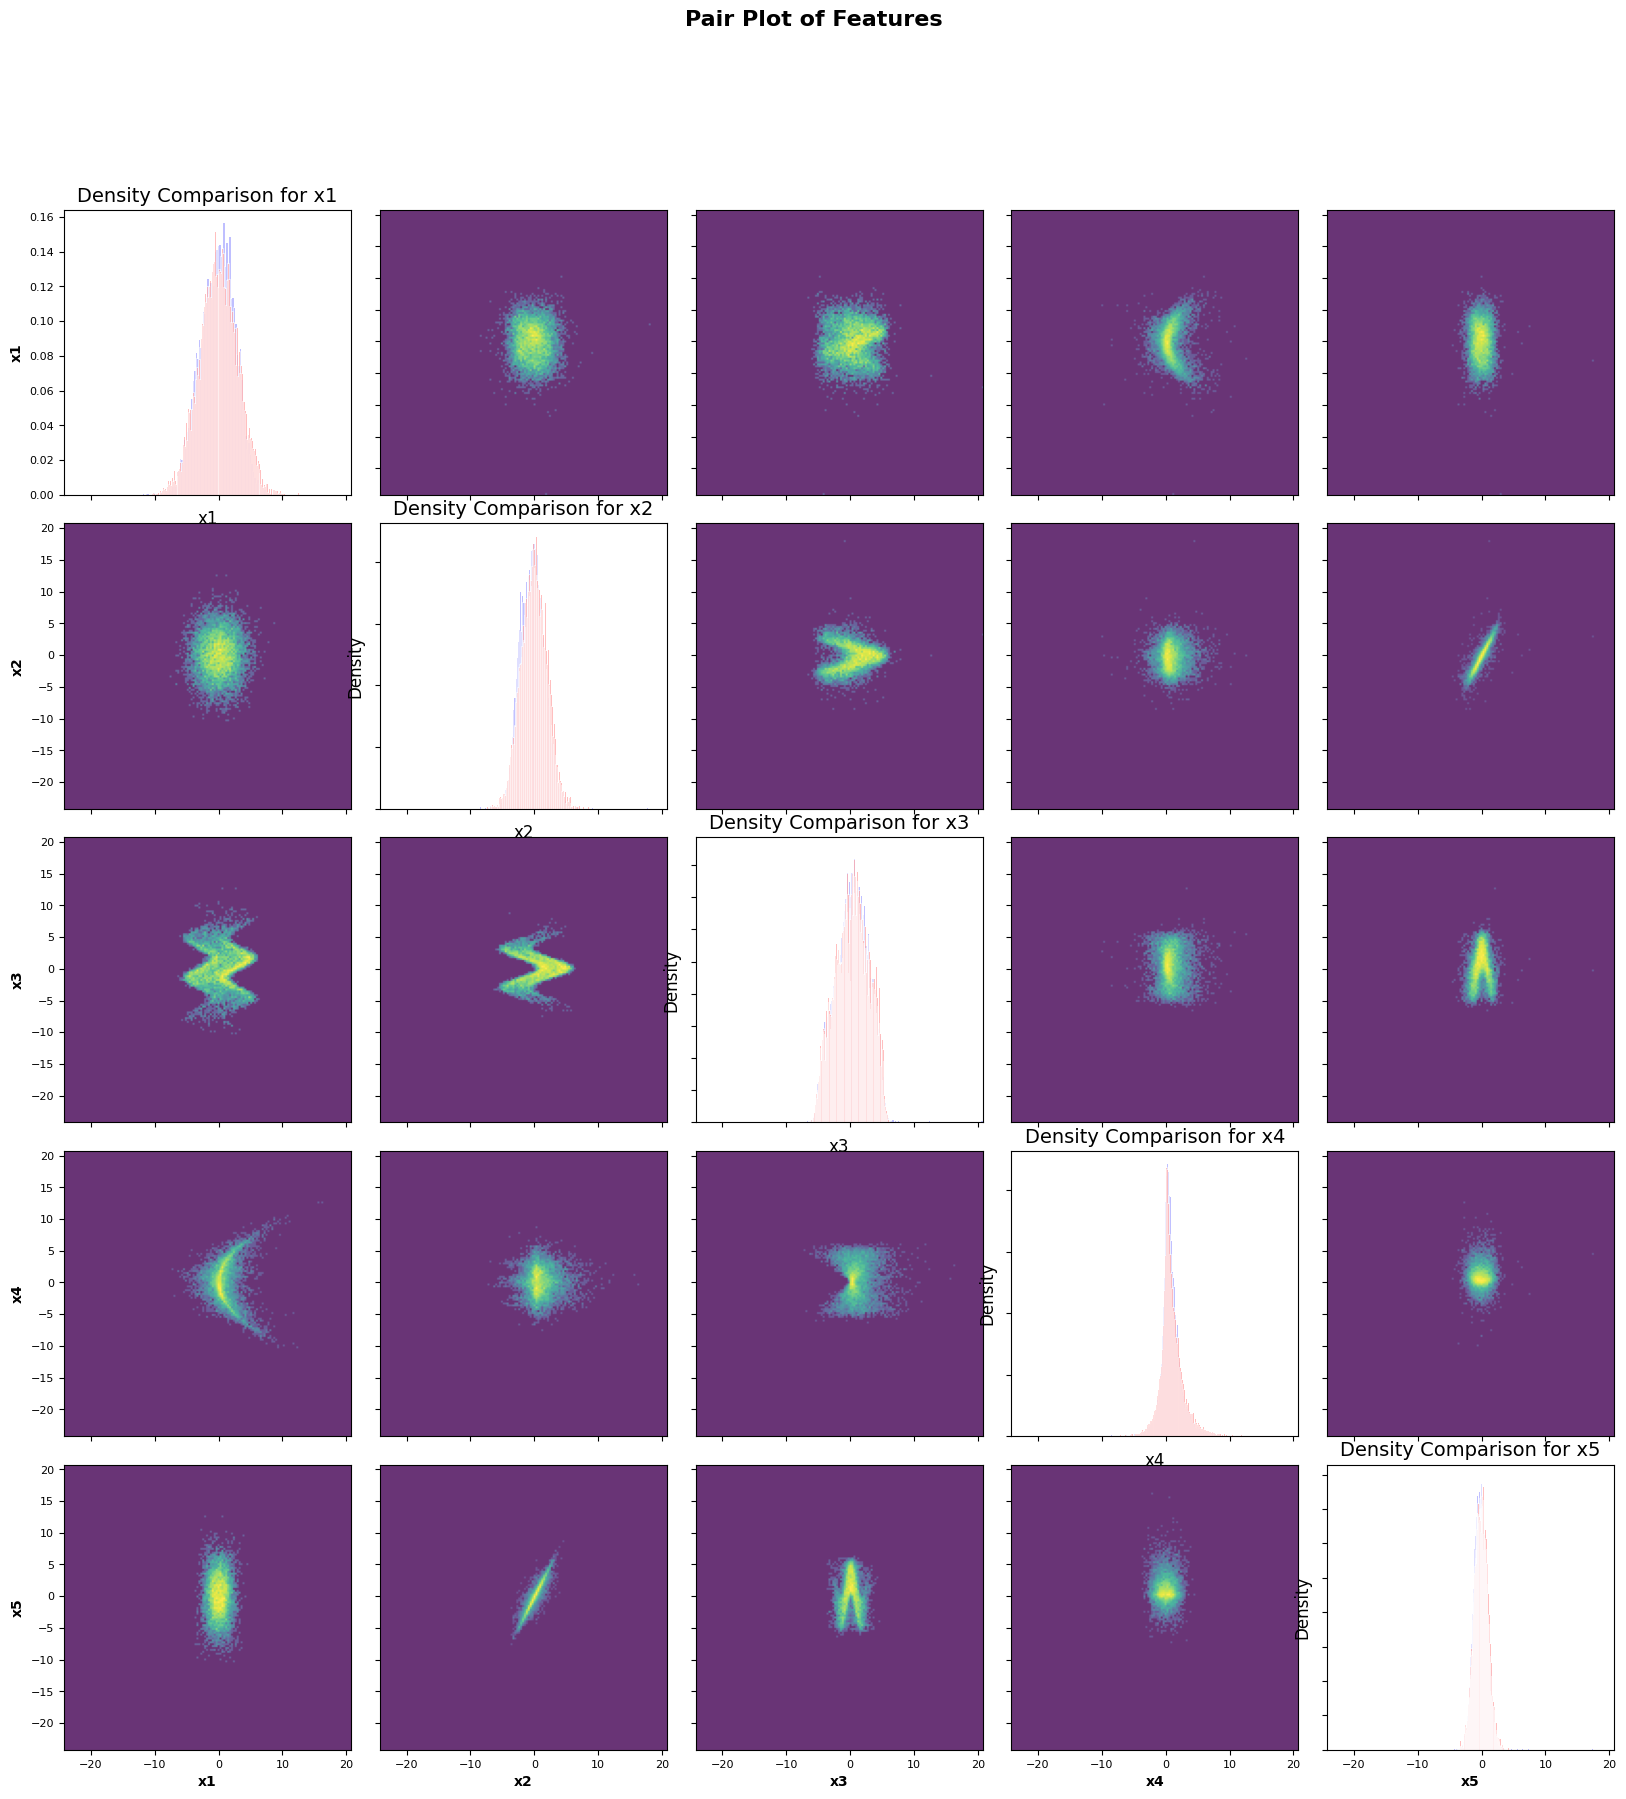

In [22]:
samples = denormalize_data(samples, means, stds)

samples_new = samples[:,-1,:]
#Hint bottom is the version with constraints, upper one the real data 
plot_pairplot_comp_kde2(samples_new2,data_new,labels)